# One-way ANOVA
This is a test to compare the means of groups that are comprised of one factor, in this case, the average `Strength` of each `Material`.

For each group, you need enough samples. Below are rules of thumb for different group cardinalities
* 2 – 9 groups: At least 15 in each group
* 10 – 12 groups: At least 20 per group

In [1]:
import os
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv(os.path.join(os.path.abspath(""), "data/anova_posthoc_tests.csv"))

In [3]:
df.describe()

,Strength
count,24.000000
mean,36.587500
std,5.080937
min,24.900000
25%,34.375000
50%,37.700000
75%,39.925000
max,45.900000


In [4]:
df.Material.unique()

array(['B', 'C', 'D', 'A'], dtype=object)

### Quick look at data
It appears as though Material `B` is considerably weaker than the rest, but no clear or compelling case for the others. they look similar.

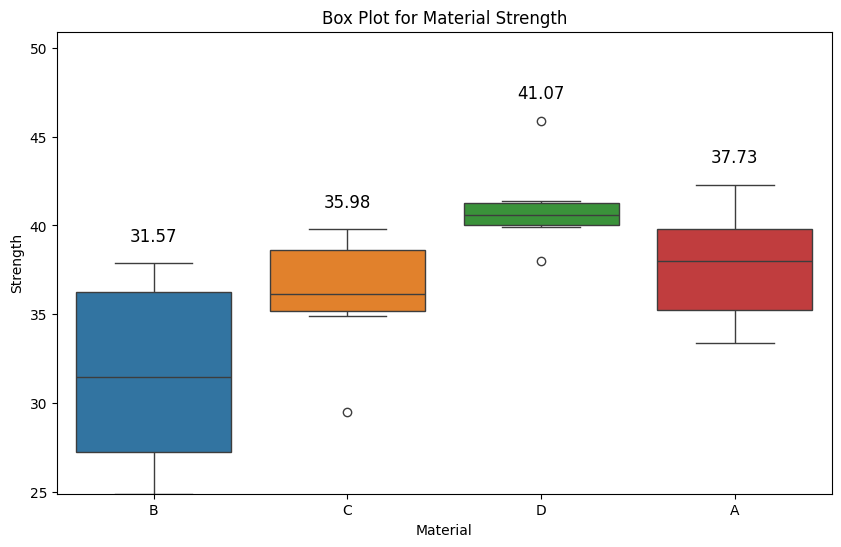

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Material', y='Strength', hue='Material', data=df)
means = df.groupby('Material')['Strength'].mean().reset_index()

for i, material in enumerate(df['Material'].unique()):
    material_data = df[df['Material'] == material]['Strength']
    max_val = material_data.max()
    y = means.loc[means['Material'] == material, 'Strength'].values[0]
    plt.text(i, max_val + 1, f'{y:.2f}', color='black', ha='center', va='bottom', fontsize=12)

plt.ylim(df['Strength'].min(), df['Strength'].max() + 5)
plt.title('Box Plot for Material Strength')
plt.show()

In [6]:
model = ols('Strength ~ C(Material)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq    df         F    PR(>F)
C(Material)  281.697917   3.0  6.017868  0.004297
Residual     312.068333  20.0       NaN       NaN


## The F-test in ANOVA

The f-statistic for `k` groups is
$$
F=\frac{\text{between groups variance}}{\text{within groups variance}}=\frac{\frac{1}{k-1}\sum{n_i(\overline{x_i}-\overline{x})^2}}{\frac{1}{N-k}\sum(n_i−1)s^{2}_i}
$$
where 
* $i$ is group index
* $N$ is total number of samples in all groups
* $s^{2}_i$ is the variance of the $i^{th}$ group
* $n_i$ is the number of samples in group $i$

The concept is that we want the "$\text{between groups variance}$", or the group means to be very different from the global mean, meaning they are spread out, causing the numerator to increase.

The "$\text{within groups variance}$", or the weighted average of the within group variances to be small. This means that the group data is grouped tightly and causes the denominator to be smaller.

To obtain a statistically significant result, the value of the $F$ statistic must be above a certain threshold, determined by degrees of freedom.

In our example, we have a statistically significant result (`PR(>F) < 0.05`)

In [7]:
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:               Strength   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     6.018
Date:                Sun, 07 Jul 2024   Prob (F-statistic):            0.00430
Time:                        16:33:57   Log-Likelihood:                -64.837
No. Observations:                  24   AIC:                             137.7
Df Residuals:                      20   BIC:                             142.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           37.7333      1.613  

In [8]:
conf_int = model.conf_int()
print(conf_int)

                          0          1
Intercept         34.369450  41.097217
C(Material)[T.B] -10.923916  -1.409417
C(Material)[T.C]  -6.507249   3.007249
C(Material)[T.D]  -1.423916   8.090583


In [9]:
means = model.params
means

Intercept           37.733333
C(Material)[T.B]    -6.166667
C(Material)[T.C]    -1.750000
C(Material)[T.D]     3.333333
dtype: float64

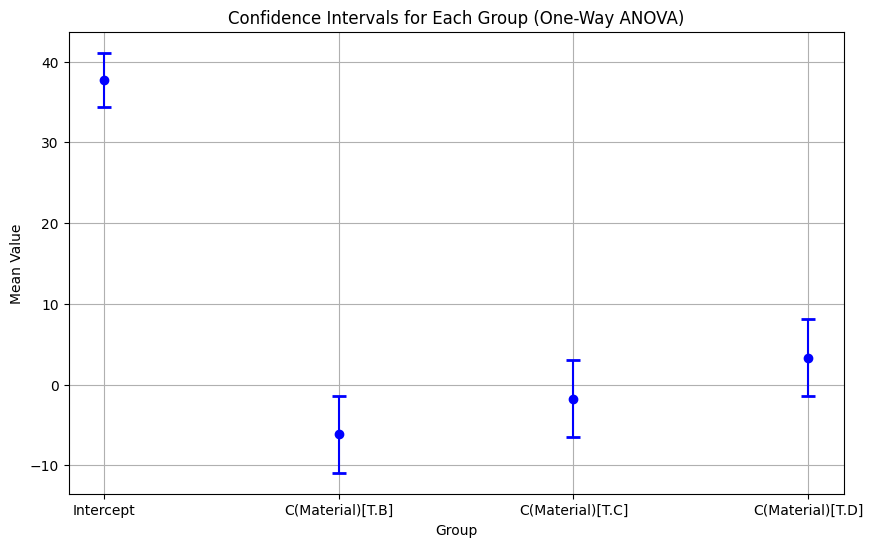

In [10]:
errors = means - conf_int[0]

plt.figure(figsize=(10, 6))
plt.errorbar(means.index, means, yerr=errors, fmt='o', capsize=5, capthick=2, color='blue')
plt.title('Confidence Intervals for Each Group (One-Way ANOVA)')
plt.xlabel('Group')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()

## Perform Tukey's HSD test

In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['Strength'], groups=df['Material'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -6.1667 0.0606 -12.5499  0.2166  False
     A      C    -1.75 0.8681  -8.1333  4.6333  False
     A      D   3.3333 0.4779  -3.0499  9.7166  False
     B      C   4.4167  0.245  -1.9666 10.7999  False
     B      D      9.5 0.0025   3.1167 15.8833   True
     C      D   5.0833 0.1495  -1.2999 11.4666  False
-----------------------------------------------------


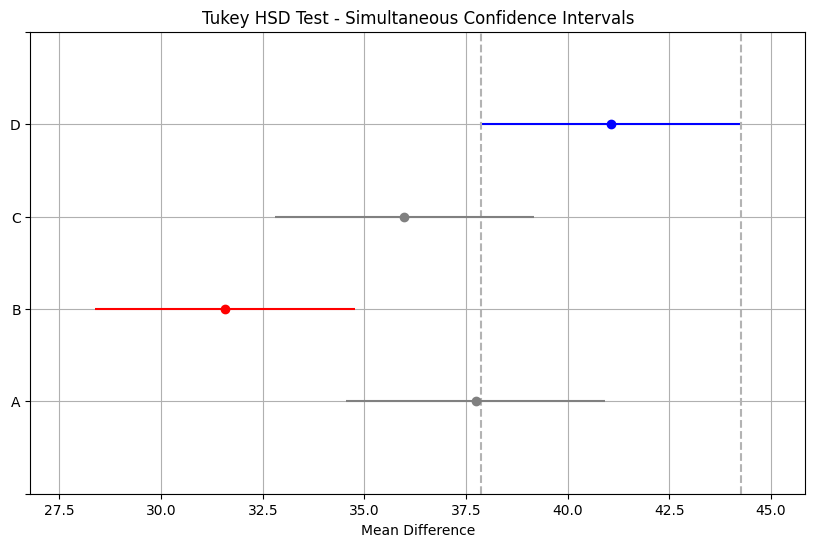

In [12]:
tukey_plot = tukey.plot_simultaneous(comparison_name='D')
plt.title('Tukey HSD Test - Simultaneous Confidence Intervals')
plt.xlabel('Mean Difference')
plt.grid(True)
plt.show()

### Custom plot for all pairwise comparisons

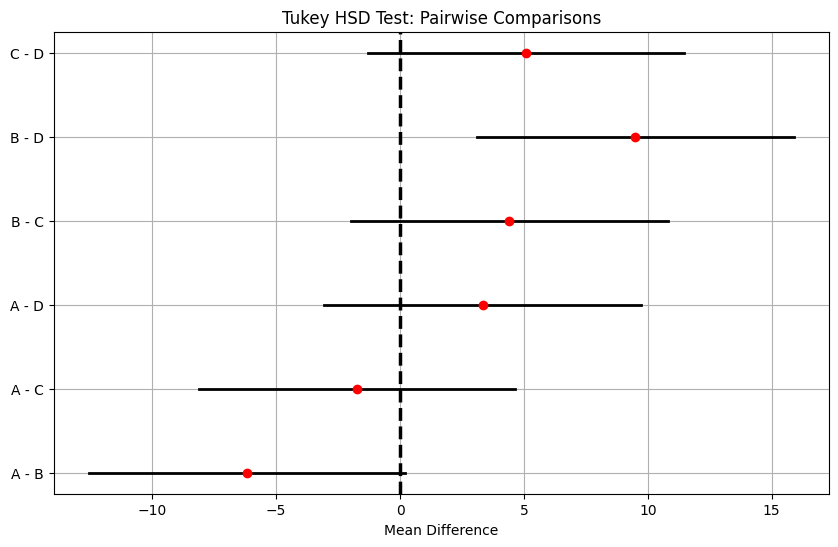

In [13]:
comparisons = tukey._results_table.data[1:]
means = [comp[2] for comp in comparisons]
conf_intervals = [(comp[4], comp[5]) for comp in comparisons]
groups = [f'{comp[0]} - {comp[1]}' for comp in comparisons]

fig, ax = plt.subplots(figsize=(10, 6))
y_range = range(len(means))

for i, (mean, (ci_low, ci_high)) in enumerate(zip(means, conf_intervals)):
    ax.plot([ci_low, ci_high], [i, i], 'k-', lw=2)
    ax.plot(mean, i, 'ro')

ax.set_yticks(y_range)
ax.set_yticklabels(groups)
ax.set_xlabel('Mean Difference')
ax.set_title('Tukey HSD Test: Pairwise Comparisons')
ax.grid(True)
ax.axvline(x=0, color='black', linestyle='--', linewidth=2.5)
plt.show()